# Homework 4 - Applied Machine Learning

This notebook corresponds the Homework 4. Firsly, we are going to explore and clean the data we have. Then, we are going to process some Machine Learning on these data.

We are going to work with the data from the CrowdstormingDataJuly1st.csv file, which represent all players playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees that these players played under in their professional career. Each row of the tables is a dyad containing information about a player given by a specific referee (for example the number of yellow cards given by this referee to the player) and also some statistics about racial bias in the referee's home country.


Our objectif is to determine the skin color of a player depending on its characteristics. In the first part, we are going to do some supervised machine learning by training a classifier. The second task will consist in processing some unsuppervised machine learning by clustering the data. 

### Imports

We start with the usual imports

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

### Uploading the data

In [2]:
filename = 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

# 0. Data Exploration and cleaning

Let's observe our data structure. First we see that we have 146028 initial rows with 28 parameters each.

In [3]:
df.shape

(146028, 28)

The 10 first parameters of the lines 100 to 105 are shown bellow. (We look at the parameters in two tables for better vizualisation)

In [4]:
df.head()
df.ix[100:105,:12]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats
100,fousseni-diawara,Fousseni Diawara,AC Ajaccio,France,28.08.1980,183.0,71.0,NaN,1,0,1,0
101,franck-signorino,Franck Signorino,Stade Reims,France,19.09.1981,173.0,69.0,Left Fullback,2,2,0,0
102,francois-marque,François Marque,SC Bastia,France,31.07.1983,187.0,85.0,Center Back,2,0,1,1
103,frederic-duplus,Frédéric Duplus,FC Sochaux,France,07.04.1990,175.0,66.0,Left Fullback,1,0,1,0
104,frederic-sammaritano,Frédéric Sammaritano,AC Ajaccio,France,23.03.1986,162.0,61.0,NaN,6,1,3,2
105,gael-angoula,Gaël Angoula,SC Bastia,France,18.07.1982,177.0,75.0,NaN,1,1,0,0


In [5]:
df.ix[100:105,12:]

,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
100,0,0,0,0,18905.jpg,0.75,1.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
101,0,0,0,0,11653.jpg,0.00,0.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
102,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
103,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
104,0,0,0,0,124957.jpg,0.25,0.25,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
105,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


The parameters *rater1* and *rater2* are skin rating of the player photo given by two differents raters (5-point scale ranging from “very light skin” (0.00 value) to “very dark skin” (1.00 value)).

We observe that there are some NaN values for rater1 and rater2. In these cases, no picture was available for this player. The correlation seems obvious because the raters used the player photo to determine its skin color, but let's verify it:

In [6]:
notRatedAtAll = (df.rater1.isnull() & df.rater2.isnull())
partiallyRated = (df.rater1.isnull() | df.rater2.isnull())
photoMissing = df.photoID.isnull()

print("Both rates missing iff one rate missing: {}".format( all(notRatedAtAll == partiallyRated)))

print("Photo missing iff rating missing: {}".format( all(notRatedAtAll == photoMissing)))

Both rates missing iff one rate missing: True
Photo missing iff rating missing: True


Our objectif is to determine the skin color of a player depending on its characteristics with the use of a classifier. Therefore, the players for which we don't have any information on their skin color will not be interesting for us. We can therefore drop theses specific rows.

Let's check how many rows is concerned by this lack of information

In [7]:
(df.photoID.isnull()).sum()

21407

In [8]:
df.shape

(146028, 28)

In [9]:
21407/146028*100

14.659517352836444

Therefore, more or less 14.7% of our data are concerned by this lack, but we don't have any other choice that drop them because theses rows do not bring us more information.

In [10]:
df = df[(df.photoID.isnull() == False)]
df.shape

(124621, 28)

Let's check if we correctly removed all the NaNs for the rater1 and rater2 parameters

In [11]:
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

Note also that we don't need the the parameter photoID anymore, so we can drop it:

In [12]:
df = df.drop(['photoID'], axis=1)

Here, we have an other problem. For many entries (28907, i.e 23%), the two raters do not give us similar result.

In [13]:
(df.rater1 != df.rater2).sum()

28907

In [14]:
28907 / 124621 * 100

23.195930059941745

In order to counter this issue, we can take the euclidian mean value between the two rates of each row. Let's observe that the mean value representes correctly the situation. Let's calculate the mean rate for each column and the difference between the two rates to see if sometimes the raters give opposite results.

In [15]:
ratingsDf = df[['rater1', 'rater2']].copy()

# Computing the mean
ratingsDf['avgRate'] = (ratingsDf['rater1'] + ratingsDf['rater2']) / 2

# Computing the difference
ratingsDf['diffRate12'] = ratingsDf['rater1'] - ratingsDf['rater2']

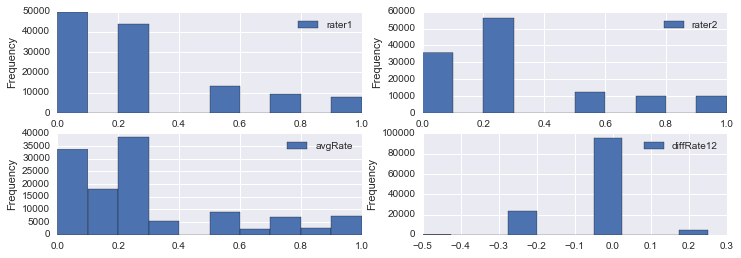

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

ratingsDf[['rater1']].plot.hist(ax=axes[0][0])
ratingsDf[['rater2']].plot.hist(ax=axes[0][1])
ratingsDf[['avgRate']].plot.hist(ax=axes[1][0])
ratingsDf[['diffRate12']].plot.hist(ax=axes[1][1]);

Firstly, we observe that most of the time, when the raters give different result, their values are only separated by 0.25, which means that the computing the mean rates should be consitent to represent the data. This is confirmed if we take a look at the average rate histogram. It looks very similar to the two rates histogram. In order to confirm that, let's get a look at the correlation matrix:

In [17]:
ratingsDf.corr()

,rater1,rater2,avgRate,diffRate12
rater1,1.000000,0.923467,0.980837,0.215314
rater2,0.923467,1.000000,0.980523,-0.175843
avgRate,0.980837,0.980523,1.000000,0.020925
diffRate12,0.215314,-0.175843,0.020925,1.000000


We see that the correlation of the *avgRate* is very high for both raters. Therefore, let's replace rater1 and rater2 values by their mean in our data and use it for further analysis.

In [18]:
# We create a new column in our data set with the mean value
df['avgRate'] = ratingsDf[['avgRate']]

# Remove the columns of rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [19]:
df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,avgRate
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


We are interested by determing the skin color of each player. Therefore, we need to regroup the entries by player, applying the mean on each values.

In [20]:
df_by_player = df.groupby("playerShort")
df_players = df_by_player.agg(np.mean)
df_players.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,avgRate
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065,0.125
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993,0.125
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032,0.250
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522,0.000
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296,0.250


In this case, the attributes *reNum*, *refCountry*, *nIAT*, *nExp* do not make any sense, and we can drop them. We are also going to drop *seIAT* and *seExp* parameters.

In [21]:
df_players = df_players.drop(['refNum', 'refCountry', 'nIAT', 'seIAT', 'nExp', 'seExp'], axis=1)

In [22]:
df_players.shape

(1585, 13)

We observe that we have a total of 1585 football players in our data. Note also that we still have some entries filled with NaN. Let's drop them.

In [23]:
df_players.isnull().any()

height          True
weight          True
games          False
victories      False
ties           False
defeats        False
goals          False
yellowCards    False
yellowReds     False
redCards       False
meanIAT        False
meanExp        False
avgRate        False
dtype: bool

In [24]:
df_players = df_players[(df_players.height.isnull() == False)]
df_players = df_players[(df_players.weight.isnull() == False)]

In [25]:
df_players.isnull().any()

height         False
weight         False
games          False
victories      False
ties           False
defeats        False
goals          False
yellowCards    False
yellowReds     False
redCards       False
meanIAT        False
meanExp        False
avgRate        False
dtype: bool

In [26]:
df_players.shape

(1564, 13)

We observe now that we have 1564 players left in our *cleaned* data set.

# 1. Machine Learning - Random Forest

Now that we have made some preprocessing on the data set and keep the useful parameters for our analysis, we can start performing some Maching Learning. We will use a Random Forest classifier. The following materials are helpful to understand the tool *scikit* we are using.

https://github.com/justmarkham/scikit-learn-videos

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

We import the library:

In [27]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

The random forest classifier seems appropriate to use in our case, because we don't know much about our data.

We cite Wikipedia because we think it captures well the spirit of our approach:


*Decision trees are a popular method for various machine learning tasks. Tree learning "come[s] closest to meeting the requirements for serving as an off-the-shelf procedure for data mining", say Hastie et al., because it is invariant under scaling and various other transformations of feature values, is robust to inclusion of irrelevant features, and produces inspectable models. However, they are seldom accurate.[3]:352
In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance.[3]:587–588 This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.*

Before doing any further anaylsis, it is important to say that there is two differents approach on how to train the classifier. 
* The first idea would be to train the model with the labels $y_{avg}$ determined using the average rate of skin darkness (average number between *rater1* and *rater2*). **It is the method we are going to use for the rest of the exercise**. It seems to be a good method because we have no other way to verify which of the raters are giving the right result.
* The second approach would be to separately fit two models to *rater1* and *rater2*, apply each model to new input data, and to take the average rating in the end. However, this claims that *rater1* and *rater2* have different characteristics. Fitting the models on the data where half of the raters were interchanged would lead to different models, which is not ideal.

First of all, we need to change the labels to discrete values, because we use a random forest classifier. Let's say that if a player has an average rate *avgRate* over or equal to 0.5, we will consider that his skin is dark. Otherwise, we will say that the player is white. Therefore, we can assign a label for each player:
* 0 for white player
* 1 for black player


In [28]:
def defining_skin_color(x):
    if(x['avgRate'] < 0.5):
        return 0
    else:
        return 1

In [29]:
df_players['skin color'] = df_players.apply(defining_skin_color, axis=1)

Let's now compute the number of *black* players in our data:

In [30]:
df_players['skin color'].sum()

378

In [31]:
df_players.shape[0]

1564

In [32]:
df_players['skin color'].sum() / df_players.shape[0] * 100

24.168797953964194

We observe that more or less 25% of the players (378) are considerated as black. Therfore the two classes (black and white people) do not have the same importance or representation number in the data, i.e the distribution is highly screwed. This can be a big issue when we training the model.

First, let's start training our random forest classifier with the simplest parameters possible, say *height* and *weight* of the players. We train and test on the whole data set.

In [33]:
X = df_players[['height', 'weight']]
y = df_players['skin color']
classifier = RandomForestClassifier(n_estimators=100, max_depth=2)
classifier.fit(X,y)

y_pred = classifier.predict(X)
print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 76.1%


We obtain an accuracy of 76.1% which seems to be a good first prediction. However, we need to be careful with this result, because first the reslut may be bias: we trained and tested our model on the same data set. Secondly, 76.1% is exactly the number of white players in our data, which means that a dummy classifier that return always a constant predition would get the same accuracy.

Let's check the *y_pred* we obtained:

In [34]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
y_pred.sum()

4

We observe that our model is really bad... The classifier almost always return 0. This makes sense because we cannot classify skin color only with height and weight information of a person. It let us highlight the fact that **is not becaue we have good percentage accuracy that our model is good. We need to understand our data and be aware of what happens behind.**

Let observe now what happens if we add more features to train our data. We can add all the information about the player football games, say number of yellow cards he got or games he played for example. We don't take yet the parameters take concern racisim information.

In [36]:
parameters = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
X = df_players[parameters]
y = df_players['skin color']
classifier = RandomForestClassifier(n_estimators=100, max_depth=2)
classifier.fit(X,y)

y_pred = classifier.predict(X)
print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 76.2%


In [37]:
y_pred.sum()

5

Well... we observe that it didn't influence much our previous conclusion... Let's observe what we obtained with a 20 folds cross validation in order to get rid of the bias values that we have by training and testing on the same data set.

In [38]:
cross_validation = cross_val_score(classifier, X, y, cv=20, scoring='accuracy')
cross_validation

array([ 0.75949367,  0.75949367,  0.74683544,  0.75949367,  0.7721519 ,
        0.75949367,  0.75641026,  0.75641026,  0.75641026,  0.75641026,
        0.74358974,  0.76923077,  0.75641026,  0.75641026,  0.75641026,
        0.75641026,  0.75641026,  0.75641026,  0.76623377,  0.77922078])

In [39]:
pd.Series(cross_validation).describe()

count    20.000000
mean      0.758967
std       0.007922
min       0.743590
25%       0.756410
50%       0.756410
75%       0.759494
max       0.779221
dtype: float64

These results seem to confirm the previous conclusion, which is that everything is classified as the same class. This can be conclude, because we have a large bias but a small variance (i.e small standard deviation).

Let's consider now all the 13 parameters and see what is going on.

In [40]:
parameters = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'meanExp']
X = df_players[parameters]
y = df_players['skin color']
classifier = RandomForestClassifier(n_estimators=100, max_depth=2)
classifier.fit(X,y)

y_pred = classifier.predict(X)
print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 77.4%


In [41]:
y_pred.sum()

27

Well, something changed here. We observe that the number of found *black* players increased, but it is still not really what we expected. Let's observe what we obtained with the 20 folds cross validaition:

In [42]:
cross_validation = cross_val_score(classifier, X, y, cv=20, scoring='accuracy')
cross_validation

array([ 0.7721519 ,  0.79746835,  0.78481013,  0.7721519 ,  0.7721519 ,
        0.74683544,  0.78205128,  0.74358974,  0.75641026,  0.78205128,
        0.74358974,  0.78205128,  0.74358974,  0.76923077,  0.75641026,
        0.76923077,  0.75641026,  0.80769231,  0.76623377,  0.77922078])

In [43]:
pd.Series(cross_validation).describe()

count    20.000000
mean      0.769167
std       0.017938
min       0.743590
25%       0.756410
50%       0.770691
75%       0.782051
max       0.807692
dtype: float64

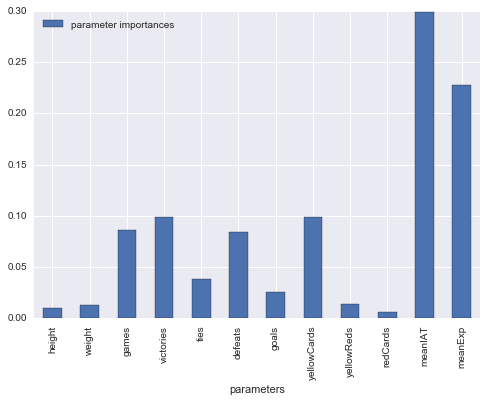

In [44]:
df_parameters_importances = pd.DataFrame({"parameters": parameters, "parameter importances": classifier.feature_importances_})
df_parameters_importances = df_parameters_importances.set_index("parameters")
df_parameters_importances.plot(kind="bar");

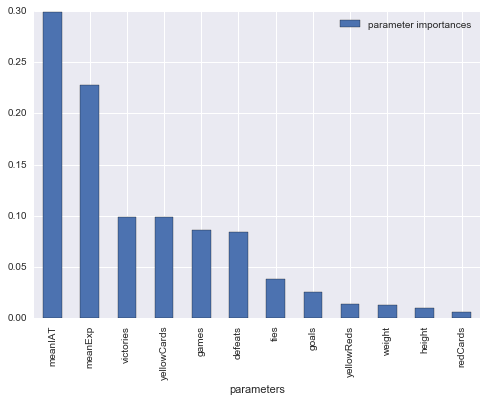

In [45]:
df_parameters_importances = df_parameters_importances.sort_values("parameter importances", ascending=False)
df_parameters_importances.plot(kind="bar");

In [59]:
metrics.confusion_matrix(y, y_pred)

array([[1185,    1],
       [ 352,   26]])